In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_tabz.csv")

metric = "Accuracy"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LogisticRegressor' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNClassifier': 'TabPFN',
    'GPBoost_Accuracy': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

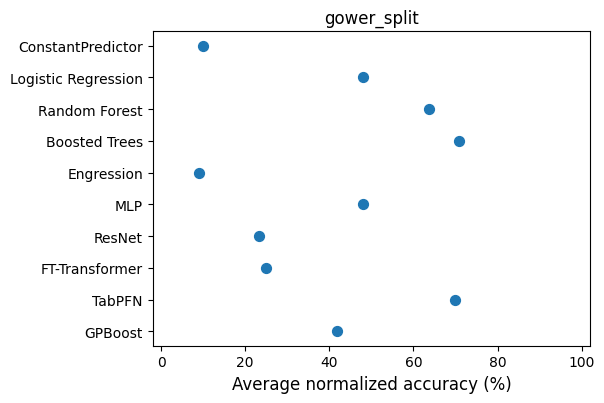

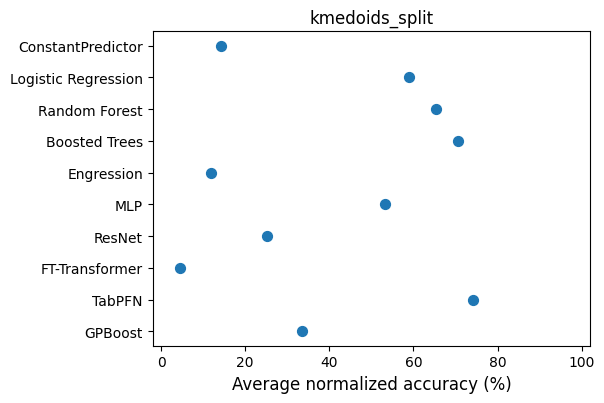

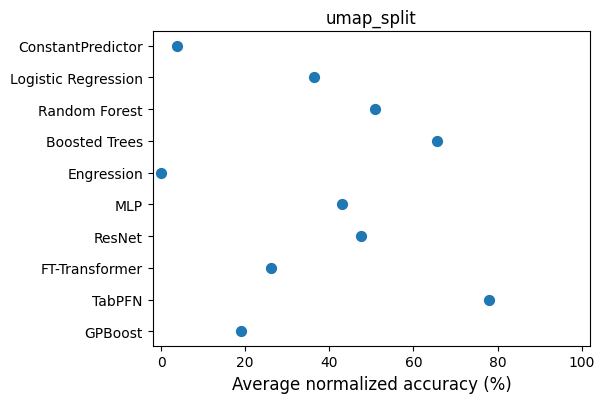

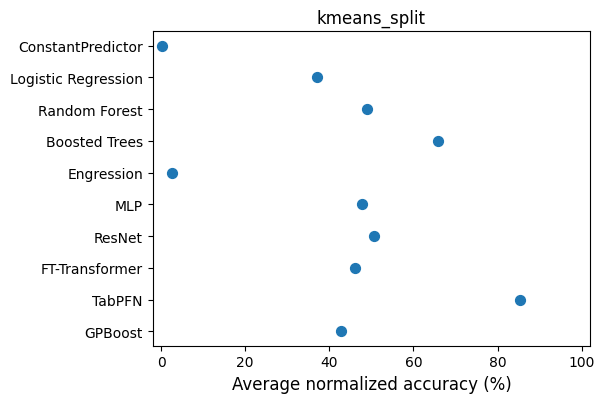

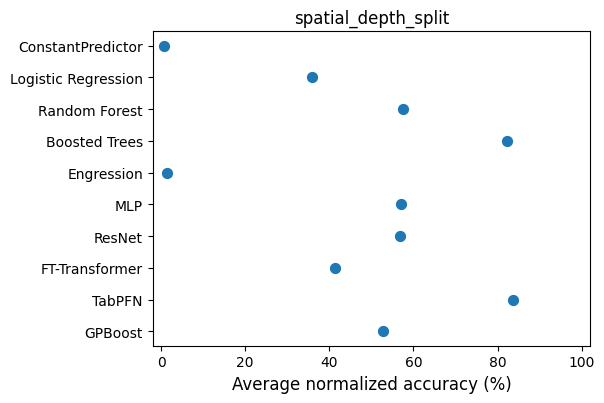

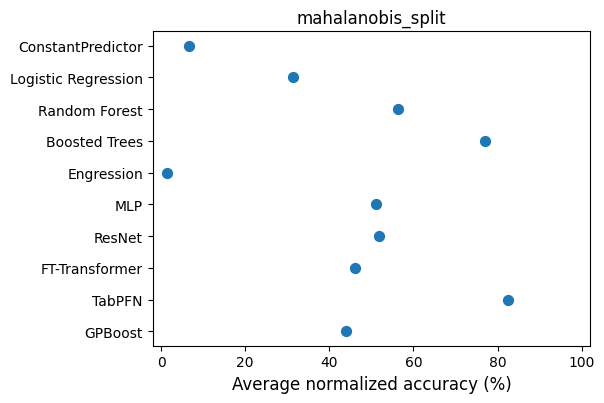

In [3]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

display_order = []
for m in method_order:
    name = rename_map.get(m, m)
    if name not in display_order:
        display_order.append(name)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.max(axis=0)
    def third_largest(series: pd.Series) -> float:
        return series.dropna().nsmallest(3).max()


    mid_err  = table.apply(third_largest, axis=0)

    norm_acc = (table - mid_err).div(baseline - mid_err, axis=1).clip(0, 1)

    summary = pd.DataFrame({
        "Mean": norm_acc.mean(axis=1),
        "Median": norm_acc.median(axis=1),
        "Std": norm_acc.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    # Reindex to consistent display order and drop methods absent in this split
    plot_df = (summary
            .set_index("Method")
            .reindex(display_order)
            .dropna(subset=["Mean"])
            .reset_index())

    # Horizontal dot plot (like your overall)
    ypos = np.arange(len(plot_df))
    fig, ax = plt.subplots()
    ax.scatter(plot_df["Mean"].values, ypos, s=50)
    ax.set_yticks(ypos)
    ax.set_yticklabels(plot_df["Method"])
    ax.invert_yaxis()        # best at top
    ax.set_xlim(-2, 102)      # normalized accuracy in %
    ax.set_xlabel("Average normalized accuracy (%)")
    ax.set_ylabel("")
    ax.grid(False)
    ax.set_title(str(split)) # label the split
    plt.tight_layout()

    # save (PDF keeps text/vector crisp for LaTeX; change to .png if you prefer)
    safe_split = str(split).replace(" ", "_").replace("/", "-")
    fname = f"{safe_split}_normalized_tabz_acc_{metric}.pdf"
    plt.savefig(os.path.join(outdir, fname), bbox_inches="tight")
    plt.show()
    plt.close()




In [4]:
df = df[df["metric"] == "Accuracy"]

df = df[df["split_method"] != "random_split"]


=== RAW normalized_accuracy sample ===
      split_method  task_id                   model     value  baseline  \
4      gower_split       10       LogisticRegressor  0.666667  0.733333   
6      gower_split       10       ConstantPredictor  0.533333  0.733333   
8   kmedoids_split       10       LogisticRegressor  0.741935  0.741935   
10  kmedoids_split       10       ConstantPredictor  0.612903  0.741935   
12      umap_split       10       LogisticRegressor  0.833333  0.900000   
14      umap_split       10       ConstantPredictor  0.366667  0.900000   
19     gower_split       10        GPBoost_Accuracy  0.300000  0.733333   
21  kmedoids_split       10        GPBoost_Accuracy  0.129032  0.741935   
23      umap_split       10        GPBoost_Accuracy  0.800000  0.900000   
29     gower_split       10              Engression  0.266667  0.733333   
31     gower_split       10                     MLP  0.733333  0.733333   
32     gower_split       10                  ResNet  0.26666

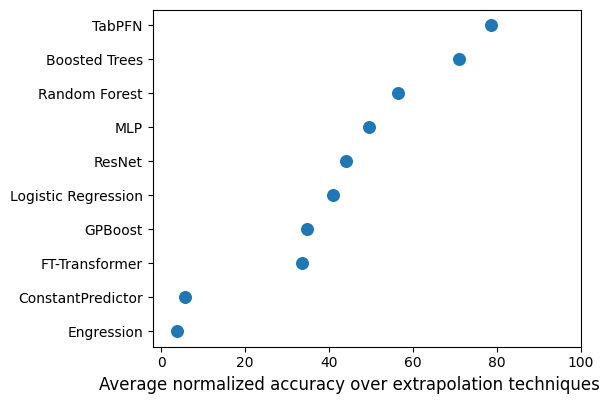

In [5]:
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nsmallest(3)
    return vals.max() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("max")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','TabPFNClassifier', 'GPBoost_Accuracy'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':   'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy':     'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])
df["Method"] = df["model"].map(rename_map).fillna(df["model"])
stats = (df.groupby("Method")["normalized_accuracy"]
           .agg(mean="mean", std="std", count="count"))
stats["se"] = stats["std"] / np.sqrt(stats["count"]).replace(0, np.nan)
stats = (stats.sort_values("mean", ascending=False) * 100)  # percent

# 4) horizontal dot plot (readable labels, optional error bars)
ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats["mean"].values, ypos, s=70)
#ax.errorbar(stats["mean"].values, ypos, xerr=None, fmt="o", ms=6, capsize=3, ls="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Average normalized accuracy over extrapolation techniques (%)")
ax.set_ylabel("")
plt.xlim(-2, 100)
ax.grid(False)
plt.tight_layout()

# 5) vector export (crisp in LaTeX)
import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/avg_normalized_acc_over_ext_tabz_Accuracy.pdf", bbox_inches="tight")
plt.show()
plt.close()

